# **Ian Yung (icy4r)**

## 1.31.2024

## M03_Homework_icy4r.ipynb

In [1]:
import pandas as pd
import numpy as np

/var/folders/c_/pj7tcp6d3w15s5d8gn2j4qth0000gn/T/ipykernel_19972/2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from textimporter import TextImporter

### Import the Text

In [3]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_dir = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [4]:
src_file = f"{data_dir}/gutenberg/pg42324.txt"
ohco_pats = [('chap', r'^(?:LETTER|CHAPTER)\b', 'm')]
clip_pats = [r'START', r'END']

In [5]:
book = TextImporter(src_file, ohco_pats=ohco_pats, clip_pats=clip_pats) 

In [6]:
book.import_source().parse_tokens()

Importing  /Users/ianyung/UVA/DS5001/data/gutenberg/pg42324.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^(?:LETTER|CHAPTER)\b
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by delimitter [.?!;:]+
Parsing OHCO level 3 token_num by delimitter [\s',-]+


In [7]:
book.TOKENS.head(10)

token_str     term_str
chap_id para_num sent_num token_num                          
1       0        0        0                  _To           to
                          1                  Mrs          mrs
                 1        1              Saville      saville
                          2              England      england
                 2        0                    _             
        1        0        0                   St           st
                 1        1          Petersburgh  petersburgh
                          2                  Dec          dec
                 2        1                 11th         11th
                          2                   17           17

In [8]:
book.extract_vocab()

In [9]:
book.VOCAB[['n']]

,n
term_str,
the,4196
and,2974
i,2851
of,2646
to,2100
...,...
calamities,1
surviving,1
desertion,1


In [10]:
sents = book.gather_tokens(2).values.tolist()
sents = [l[0] for l in sents]

In [11]:
sents[:10] # contains list of sentences

['to mrs',
 'saville england',
 '',
 'st',
 'petersburgh dec',
 '11th 17',
 'you will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings',
 'i arrived here yesterday',
 'and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking',
 'i am already far north of london']

### Create the NGram

In [12]:
OHCO = book.TOKENS.index.names
def token_to_padded(token, grouper=['sent_num'], term_str='term_str'):
    ohco = token.index.names # We preserve these since they get lost in the shuffle
    padded = token.groupby(grouper)\
        .apply(lambda x: '<s> ' + ' '.join(x[term_str]) + ' </s>')\
        .apply(lambda x: pd.Series(x.split()))\
        .stack().to_frame('term_str')
    # padded.index.names = ohco
    return padded

In [13]:
PADDED = token_to_padded(book.TOKENS, grouper=OHCO[:3], term_str='term_str')

In [14]:
def padded_to_ngrams(padded, grouper=['sent_num'], n=2):
    
    ohco = padded.index.names
    ngrams = padded.groupby(grouper).apply(lambda x: pd.concat([x.shift(0-i) for i in range(n)], axis=1)).reset_index(drop=True)
    ngrams.index = padded.index
    ngrams.columns = widx

    # ngrams = pd.concat([padded.shift(0-i) for i in range(n)], axis=1)
    # ngrams.index.name = 'ngram_num'
    # ngrams.columns = widx
    # ngrams = ngrams.fillna('<EOF>')
    
    return ngrams

In [15]:
ngrams = 2
widx = [f"w{i}" for i in range(ngrams)]
NGRAMS = padded_to_ngrams(PADDED, OHCO[:3], ngrams)

In [16]:
NGRAMS

w0        w1
chap_id para_num sent_num                       
1       0        0        0        <s>        to
                          1         to       mrs
                          2        mrs      </s>
                          3       </s>      None
                 1        0        <s>   saville
...                                ...       ...
30      82       1        11        in  darkness
                          12  darkness       and
                          13       and  distance
                          14  distance      </s>
                          15      </s>      None

[85629 rows x 2 columns]

### Create Model

In [17]:
def ngrams_to_models(ngrams):
    global widx
    n = len(ngrams.columns)
    model = [None for i in range(n)]
    for i in range(n):
        if i == 0:
            model[i] = ngrams.value_counts('w0').to_frame('n')
            model[i]['p'] = model[i].n / model[i].n.sum()
            model[i]['i'] = np.log2(1/model[i].p)
        else:
            model[i] = ngrams.value_counts(widx[:i+1]).to_frame('n')    
            model[i]['cp'] = model[i].n / model[i-1].n
            model[i]['i'] = np.log2(1/model[i].cp)
        model[i] = model[i].sort_index()
    return model

In [18]:
M = ngrams_to_models(NGRAMS)

In [19]:
M[1]

n        cp         i
w0       w1                           
1        </s>    2  1.000000  0.000000
11th     17      1  0.500000  1.000000
         the     1  0.500000  1.000000
12th     17      1  0.500000  1.000000
         </s>    1  0.500000  1.000000
...             ..       ...       ...
youthful days    1  0.333333  1.584963
         lovers  2  0.666667  0.584963
zeal     </s>    1  0.250000  2.000000
         modern  1  0.250000  2.000000
         of      2  0.500000  1.000000

[40791 rows x 3 columns]

## *Questions*

### Question 1

In [20]:
NGRAMS.query('w1 == "monster"')

w0       w1
chap_id para_num sent_num                        
11      3        17       25   miserable  monster
        15       4        5         this  monster
        18       4        4          the  monster
        21       2        4          the  monster
14      21       6        14         the  monster
15      5        4        8          the  monster
16      8        0        1     abhorred  monster
18      12       3        12         the  monster
19      16       13       4            a  monster
21      7        16       5            a  monster
        25       4        23  detestable  monster
22      26       2        0          <s>  monster
        28       0        1      hideous  monster
24      7        7        8          the  monster
        8        7        4          the  monster
25      16       1        7          the  monster
26      12       0        1          the  monster
        24       13       6          the  monster
27      10       5        9          the  monster
        44       6        9          the  monster
        47       7        51         the  monster
28      20       4        2          the  monster
        30       2        8          the  monster
29      9        4        8          the  monster
        17       1        17         the  monster
        25       3        10         the  monster
30      4        9        5      hellish  monster
        17       6        2     gigantic  monster
        30       1        21         the  monster
                 2        2            a  monster
        72       5        1          the  monster

The words preceding "monster" are:

1. miserable
2. abhorred
3. detested
4. hideous
5. hellish
6. gigantic

### Question 2

In [21]:
sents = ["The monster is on the ice.",
        "Flowers are happy things.",
        "I have never seen the aurora borealis.",
        "He never knew the love of a family."]

In [22]:
def sentence_to_token(sent_list, file=True):
    
    # Convert list of sentences to dataframe
    if file:
        S = pd.read_csv("test_sentences.txt", header=None, names=['sent_str'])
    else:
        S = pd.DataFrame(sent_list, columns=['sent_str'])
    S.index.name = 'sent_num'
    
    # Convert dataframe of sentences to TOKEN with normalized terms
    K = S.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
    K['term_str'] = K.token_str.str.replace(r"[\W_]+", "", regex=True).str.lower()
    K.index.names = ['sent_num', 'token_num']
    
    return S, K

In [23]:
TEST_SENTS, TEST_TOKENS = sentence_to_token(sents, file=False)

In [24]:
TEST_SENTS.head()

,sent_str
sent_num,
0,The monster is on the ice.
1,Flowers are happy things.
2,I have never seen the aurora borealis.
3,He never knew the love of a family.


In [25]:
TEST_TOKENS.head()

token_str term_str
sent_num token_num                   
0        0               The      the
         1           monster  monster
         2                is       is
         3                on       on
         4               the      the

In [26]:
TEST_TOKENS.loc[~TEST_TOKENS.term_str.isin(M[0].index), 'term_str'] = "<UNK>"
TEST_TOKENS[TEST_TOKENS.term_str == '<UNK>'].value_counts('token_str')

token_str
aurora       1
borealis.    1
Name: count, dtype: int64

In [27]:
TEST_PADDED = token_to_padded(TEST_TOKENS)
TEST_PADDED.head()

term_str
sent_num           
0        0      <s>
         1      the
         2  monster
         3       is
         4       on

In [28]:
TEST_NGRAMS = padded_to_ngrams(TEST_PADDED, 'sent_num', ngrams)
TEST_NGRAMS.loc[1]

,w0,w1
0,<s>,flowers
1,flowers,are
2,are,happy
3,happy,things
4,things,</s>
5,</s>,None


In [29]:
TEST_NGRAMS

w0       w1
sent_num                    
0        0      <s>      the
         1      the  monster
         2  monster       is
         3       is       on
         4       on      the
         5      the      ice
         6      ice     </s>
         7     </s>     None
1        0      <s>  flowers
         1  flowers      are
         2      are    happy
         3    happy   things
         4   things     </s>
         5     </s>     None
2        0      <s>        i
         1        i     have
         2     have    never
         3    never     seen
         4     seen      the
         5      the    <UNK>
         6    <UNK>    <UNK>
         7    <UNK>     </s>
         8     </s>     None
3        0      <s>       he
         1       he    never
         2    never     knew
         3     knew      the
         4      the     love
         5     love       of
         6       of        a
         7        a   family
         8   family     </s>
         9     </s>     None

In [30]:
def test_model(model, ngrams, sents):
    
    global widx
    
    assert len(model) == len(ngrams.columns)
    
    n = len(model)
    ohco = ngrams.index.names
    vals = ['sent_num', 'level_1', 'w0', 'w1']
    
    R = []
    for i in range(n):
        T = ngrams.merge(M[i], on=widx[:i+1], how='left')
        T.index = ngrams.index
        T = T.reset_index().set_index(vals).i
        
        # This how we handle unseen combos
        T[T.isna()] = T.max()
        R.append(T.to_frame(f"i{i}"))
                
    return pd.concat(R, axis=1)

In [31]:
R = test_model(M,TEST_NGRAMS, TEST_SENTS)

In [32]:
R

i0         i1
sent_num level_1 w0      w1                           
0        0       <s>     the       4.057417   3.816642
         1       the     monster   4.351013   7.712871
         2       monster is       11.431616  10.437752
         3       is      on        8.123717   6.262095
         4       on      the       7.543462   1.623182
         5       the     ice       4.351013   7.947336
         6       ice     </s>     10.959547   2.426265
         7       </s>    NaN       4.057417  10.437752
1        0       <s>     flowers   4.057417  10.437752
         1       flowers are      14.063884  10.437752
         2       are     happy     8.934601  10.437752
         3       happy   things   10.862250  10.437752
         4       things  </s>     13.215887   2.169925
         5       </s>    NaN       4.057417  10.437752
2        0       <s>     i         4.057417   2.650675
         1       i       have      4.908560   4.695893
         2       have    never     7.874059   6.511753
         3       never   seen     10.277287   5.108524
         4       seen    the      12.063884   3.321928
         5       the     <UNK>     4.351013  10.437752
         6       <UNK>   <UNK>    14.063884  10.437752
         7       <UNK>   </s>     14.063884  10.437752
         8       </s>    NaN       4.057417  10.437752
3        0       <s>     he        4.057417   4.910542
         1       he      never     7.135513   9.250298
         2       never   knew     10.277287  10.437752
         3       knew    the      11.385812   5.000000
         4       the     love      4.351013   9.712871
         5       love    of       10.503169   4.297681
         6       of      a         5.016215   4.536707
         7       a       family    5.948060  10.437752
         8       family  </s>     11.431616   1.954196
         9       </s>    NaN       4.057417  10.437752

In [33]:
def compute_perplexity(results, test_sents, n=2):
    for i in range(n):
        test_sents[f"pp{i}"] = np.exp2(results.groupby('sent_num')[f"i{i}"].mean())
    return test_sents

In [34]:
PP = compute_perplexity(R, TEST_SENTS)

In [35]:
PP

,sent_str,pp0,pp1
sent_num,,,
0,The monster is on the ice.,116.114169,80.615581
1,Flowers are happy things.,587.553339,533.661415
2,I have never seen the aurora borealis.,340.862249,138.671856
3,He never knew the love of a family.,170.822228,136.954718


In [36]:
Z = TEST_SENTS.copy()
Z['sent_str'] = Z.sent_str.str.replace('<s> ', '').str.replace(' </s>', '')
Z = Z.set_index('sent_str')
Z = (Z - Z.mean()) / Z.std()

In [37]:
Z['pp_mean'] = Z.mean(axis=1) # Just for sorting purposes

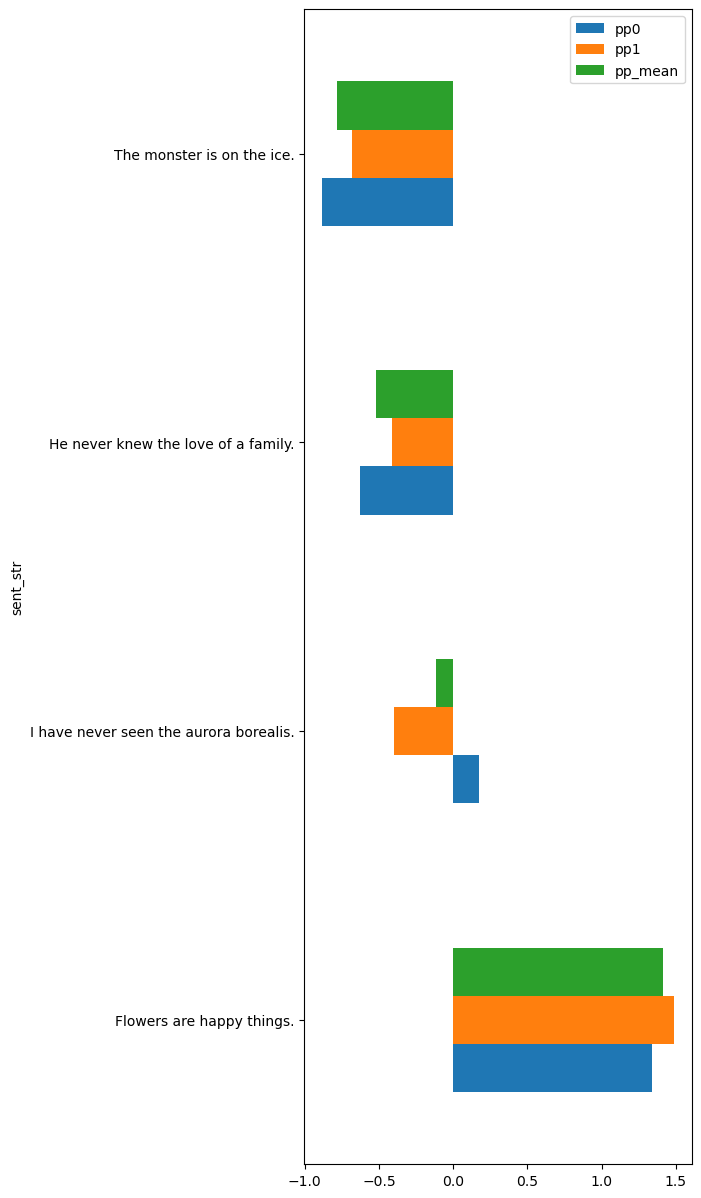

In [38]:
Z.sort_values('pp_mean', ascending=False).plot.barh(figsize=(5,15));

In terms of bigram perplexity, listing the sentences in ascending order goes:

1. Flowers are happy things.
2. I have never seen the aurora borealis.
3. He never knew the love of a family.
4. The monster is on the ice.

### Question 3

In [39]:
M[1].n.unstack().loc[['he', 'she']][['said', 'heard']]

w1,said,heard
w0,,
he,21.0,5.0
she,3.0,3.0


The above dataframe conveys the relationship pertaining to the following bigram pairs.

### Question 4

In [40]:
ngrams = 3
widx = [f"w{i}" for i in range(ngrams)]
NGRAMS = padded_to_ngrams(PADDED, OHCO[:3], ngrams)

In [41]:
M3 = ngrams_to_models(NGRAMS)

In [42]:
def generate_text(M, n=250):
    
    if len(M) < 3:
        raise ValueError("Must have trigram model generated.")
    
    # Start list of words
    first_word = M[1].loc['<s>'].sample(weights='cp').index[0]
    
    words = ['<s>', first_word]
    
    for i in range(n):
        
        bg = tuple(words[-2:])

        # Try trigram model
        try:
            next_word = M[2].loc[bg].sample(weights='cp').index[0]

        # If not found in model, back off ...
        except KeyError as e1:
            try:
                # Get the last word in the bigram
                ug = bg[1]
                next_word = M[1].loc[ug].sample(weights='cp').index[0]
            
            except KeyError as e2:
                next_word = M[0].sample(weights='p').index[0]
                
        words.append(next_word)
    
    
    text = ' '.join(words[2:])
    print('\n\n'.join([str(i+1) + ' ' + line.replace('<s>','').strip().upper() for i, line in enumerate(text.split('</s>'))]))

In [58]:
generate_text(M3)

1 ARE WELL ACQUAINTED WITH ANY INQUISITIVENESS OF MINE I SHALL RELATE EVENTS THAT PREYED ON THE GROUND

2 NO MOTHER HAD BLESSED ME WITH THEIR FORKED AND DESTROYING TONGUES

3 OBSCURED IN DARKNESS

4 TO SORROW BUT IT REQUIRES ALL MY SPECULATIONS AND HOPES DO NOT CREDIT IT

5 OATEN CAKE WHEN I AWOKE AND MY PULSE BEAT WITH A GREAT HINDERANCE TO MY PLAN WAS UNSETTLED

6 ME GENTLE YET SO WISE

7 NOR CAN I REFLECT THAT YOU MAY HATE

8 HIM TO THE TEMPER OF HER OWN SHE WAS TO BECOME A STUDENT AT THE BROOK

9 OR CAST OUR CARES AWAY

10 THAN THAT OF THE FLANNEL

11 FRANKENSTEIN

12 A RESIDENCE AS THE SEASON ADVANCED

13 STRUCK ME AND I AM ALONE AND MISERABLE FEARS TO CONTEMPLATE ITS PROGRESS

14 THE HANDS OF ELIZABETH S LETTER WE RETURNED HOPELESS MOST OF THE PURE AIR OF DIGNITY AND BEAUTY THAT HARDLY PERMITTED THE SENTIMENT OF A WELL KNOWN

15 THAT THE POLE TO THOSE THAT REMAINED TO ME WHICH NOTHING COULD DISSIPATE

16 ME HENRY TO ORDER THAT MY SWEET LADY DEAREST ELIZABETH MY LOVE REPLIED I

17

### Question 5

In [44]:
M = M3

In [45]:
M[1]['p'] = M[1].n /  M[1].n.sum()
M[2]['p'] = M[2].n /  M[2].n.sum()

In [46]:
M[2]

n   cp    i         p
w0       w1     w2                                 
11th     17     </s>          1  1.0  0.0  0.000013
         the    passage       1  1.0  0.0  0.000013
12th     17     </s>          1  1.0  0.0  0.000013
13th     17     </s>          1  1.0  0.0  0.000013
18th     17     </s>          2  1.0  0.0  0.000027
...                          ..  ...  ...       ...
youthful lovers have          1  0.5  1.0  0.000013
                while         1  0.5  1.0  0.000013
zeal     modern philosophers  1  1.0  0.0  0.000013
         of     felix         1  0.5  1.0  0.000013
                his           1  0.5  1.0  0.000013

[64767 rows x 4 columns]

In [47]:
import math

#### Unigram

In [48]:
H = 0
for i in range(len(M[0])):
    p = M[0]['p'].iloc[i]
    H_star = p * math.log2(1 / p)
    H += H_star
N = len(M[0].index)**2
H_max = math.log2(N)

# calculate redundancy
R = 1 - (H / H_max)

In [49]:
R

0.6541998121428072

#### Bigram

In [50]:
H = 0
for i in range(len(M[1])):
    p = M[1]['p'].iloc[i]
    H_star = p * math.log2(1 / p)
    H += H_star
N = len(M[1].index)**3
H_max = math.log2(N)

# calculate redundancy
R = 1 - (H / H_max)

In [51]:
R

0.6924696924102178

#### Trigram

In [52]:
H = 0
for i in range(len(M[2])):
    p = M[2]['p'].iloc[i]
    H_star = p * math.log2(1 / p)
    H += H_star
N = len(M[2].index)**4
H_max = math.log2(N)

# calculate redundancy
R = 1 - (H / H_max)

In [53]:
R

0.7529513735092883

As the choice of n-gram increases, the redundancy value *R* increases in value as well.